In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/dataset'))

['Venous Ulcer', 'Diabetic Ulcer', 'Pressure Ulcer', 'Not a wound', 'Surgical Wound']


In [ ]:
X=[]
Z=[]
IMG_SIZE=150
Venous='/content/drive/MyDrive/dataset/Venous Ulcer'
Surgical='/content/drive/MyDrive/dataset/Surgical Wound'
Diabetic='/content/drive/MyDrive/dataset/Diabetic Ulcer'
Pressure='/content/drive/MyDrive/dataset/Pressure Ulcer'
Nowound = '/content/drive/MyDrive/dataset/Not a wound'
weights_path='/content/drive/MyDrive/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [ ]:
def assign_label(img,wound_type):
    return wound_type

In [ ]:
def make_train_data(wound_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,wound_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Venous',Venous)
print(len(X))

100%|██████████| 500/500 [00:13<00:00, 35.98it/s] 

500


In [ ]:
make_train_data('Surgical',Surgical)
print(len(X))

100%|██████████| 500/500 [00:27<00:00, 18.05it/s]

1000


In [ ]:
make_train_data('Diabetic',Diabetic)
print(len(X))

100%|██████████| 500/500 [00:12<00:00, 40.11it/s] 

1500


In [ ]:
make_train_data('Pressure',Pressure)
print(len(X))

100%|██████████| 500/500 [00:13<00:00, 37.39it/s] 

2000


In [ ]:
make_train_data('Nowound',Nowound)
print(len(X))

100%|██████████| 500/500 [00:16<00:00, 30.75it/s]

2500


2.2 ) Visualizing some Random Images

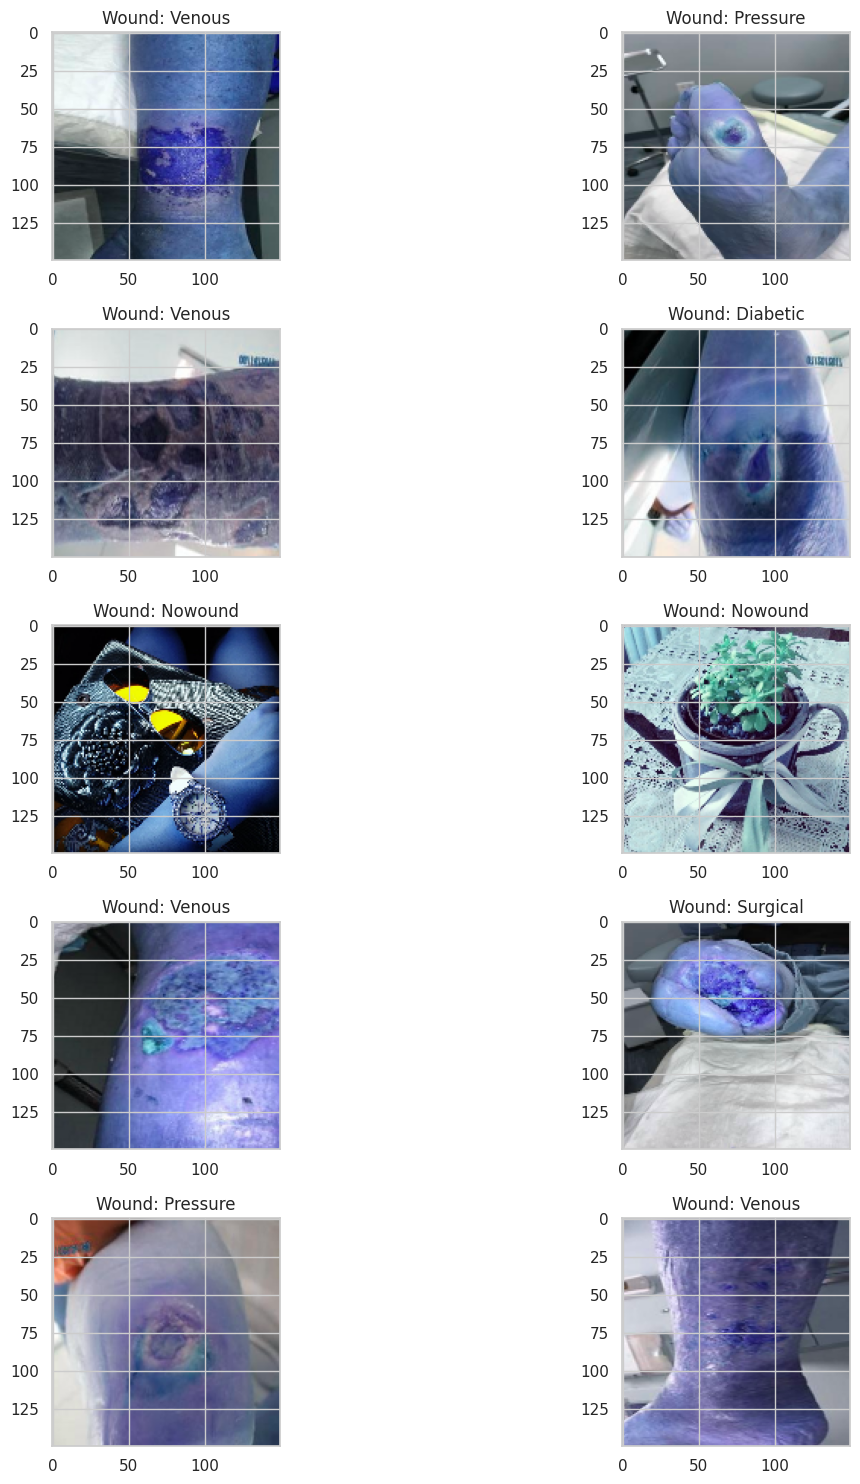

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Wound: '+Z[l])

plt.tight_layout()

2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding


In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

2.4 ) Splitting into Training and Validation Sets¶


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


In [ ]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

Modelling

3.1 ) Specifying the Base Model¶

Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model.

In our case we are using the VGG16 model from the Keras.Applications library as the base model.




In [ ]:
base_model=VGG16(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')


In [ ]:
base_model.load_weights(weights_path)


BREAKING IT DOWN--
1) Firstly we import the VGG16 module from the Keras library.

2) Next we need to specify if we want to use the fully connected layers of the VGG16 module or own layers. Since our task is different and we have only 5 target classes we need to have our own layers and I have specified the 'include_top' arguement as 'False'.

3) Next we need to specify the weights to be used by the model. Since I want it to use the weights it was trained on in ImageNet competition, I have loaded the weights from the corressponding file. You can directly specify the weights arguement as 'imagenet' in VGG16( ) but it didn't work in my case so I have to explicitily load the weghts from a file.

4) Lastly we just need to specify the shape of the imput that our model need to expect and also specify the 'pooling' type.

In [ ]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Note that this is NOT the summary of our model and this is the summary or the ARCHITECTURE of the VGG16 model that we are deploying as the base model.



3.2 ) Adding our Own Fully Connected Layers

Now we need to add at the top of the base model some fully connected layers. Alsowe can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.

In [ ]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

3.3 ) Data Augmentation to prevent Overfitting¶


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

3.4 ) Using a Learning Rate Annealer & the Summary¶


In [ ]:
epochs=25
batch_size=32
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14847301 (56.64 MB)
Trainable params: 14847301 (56.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This is now the complete summary of our model that we shall use to classify the images.



3.5 ) Compiling & Training the Model

3.5.1 ) USING BASE MODEL AS A FEATURE EXTRACTOR.

While using transfer learning in ConvNet; we have basically have 3 main approaches-->

1) To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model.

2) Fine Tuning- In this approach we tune the weights of the pretrained model. This can be done by unfreezing the layers that we want to train.In that case these layers will be initialised with their trained weights on imagenet.

3) Lasty we can use a pretrained model.

Note that in this section I have used the first approach ie I have just use the conv layers and added my own fully connected layers on top of VGG model. Thus I have trained a classifier on top of the CNN codes

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

3.5.3) UNFREEZING THE LAST 2 BLOCKS
Similarly unffreezing the last 2 blocks of the VGG16model.

In [ ]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])

for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False

0 <keras.src.engine.input_layer.InputLayer object at 0x7b71384ddcc0>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b71384dfe20>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b71383845e0>
3 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b71383841c0>
4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b7138385690>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b7138385f00>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b7138387850>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b7138387e20>
8 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b71383870d0>
9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b7138386260>
10 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b71383ea0e0>
11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b71383ea7d0>
12 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b71383eab90>
13 <keras.src.layer

In [ ]:
model.compile(optimizer=Adam(lr=0.0002),loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 15, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/15
58/58 [==============================] - 31s 356ms/step - loss: 1.6933 - accuracy: 0.2697 - val_loss: 1.2781 - val_accuracy: 0.3744
Epoch 2/15
58/58 [==============================] - 14s 243ms/step - loss: 1.2910 - accuracy: 0.4151 - val_loss: 1.1961 - val_accuracy: 0.4640
Epoch 3/15
58/58 [==============================] - 14s 246ms/step - loss: 1.1522 - accuracy: 0.4872 - val_loss: 1.2336 - val_accuracy: 0.4192
Epoch 4/15
58/58 [==============================] - 16s 269ms/step - loss: 1.1089 - accuracy: 0.5144 - val_loss: 1.1773 - val_accuracy: 0.4960
Epoch 5/15
58/58 [==============================] - 23s 396ms/step - loss: 1.1109 - accuracy: 0.5138 - val_loss: 1.0407 - val_accuracy: 0.5696
Epoch 6/15
58/58 [==============================] - 16s 269ms/step - loss: 1.0609 - accuracy: 0.5334 - val_loss: 1.3483 - val_accuracy: 0.4592
Epoch 7/15
58/58 [==============================] - 16s 268ms/step - loss: 1.0483 - accuracy: 0.5431 - val_loss: 1.0399 - val_accuracy: 0.5376

Note that there is still an increse in validation accuracy of about 1.5% and the same has now reached to about 81.5%.¶


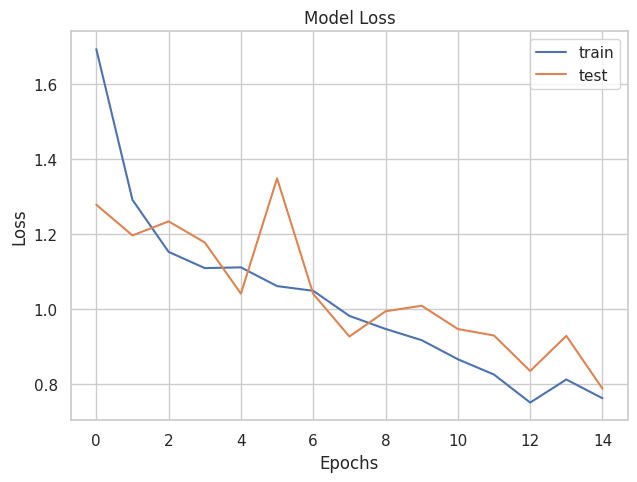

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

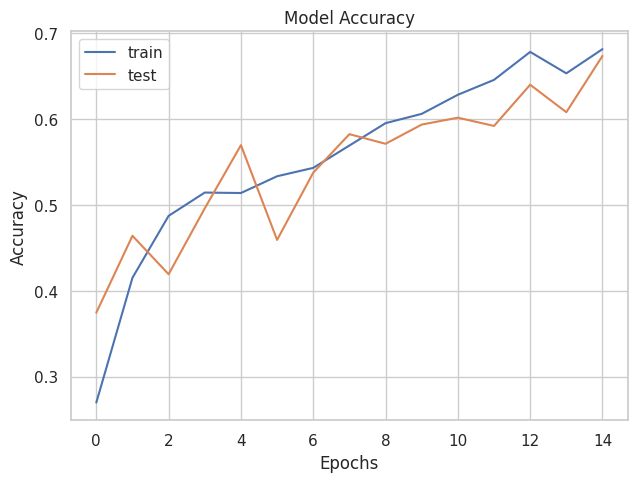

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# Evaluating the model on the test data

results = model.evaluate(x_test, y_test)
print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

20/20 [==============================] - 1s 71ms/step - loss: 0.7871 - accuracy: 0.6736
Loss of the model is -  0.7871155142784119
Accuracy of the model is -  67.36000180244446 %


In [ ]:
# Create predictions for test images
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

20/20 [==============================] - 1s 69ms/step


array([0, 3, 1, 0, 3, 3, 3, 1, 4, 1, 4, 3, 3, 4, 3])

In [ ]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

0

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    rounded_labels,
    predictions,
    target_names = ['Venous Ulcer', 'Surgical Wound', 'Diabetic Ulcer', 'Pressure Ulcer', 'Not a wound']))

                precision    recall  f1-score   support

  Venous Ulcer       0.69      0.71      0.70       127
Surgical Wound       0.94      0.92      0.93       119
Diabetic Ulcer       0.45      0.24      0.31       139
Pressure Ulcer       0.46      0.81      0.58       110
   Not a wound       0.92      0.77      0.84       130

      accuracy                           0.67       625
     macro avg       0.69      0.69      0.67       625
  weighted avg       0.69      0.67      0.66       625



In [ ]:
# Confusion matrix plot function and execute
class_names = ['Venous Ulcer', 'Surgical Wound', 'Diabetic Ulcer', 'Pressure Ulcer','Not a wound']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm,
        cmap = 'Blues',
        linecolor = 'black',
        linewidth = 1,
        annot = True,
        fmt = '',
        xticklabels = class_names,
        yticklabels = class_names)

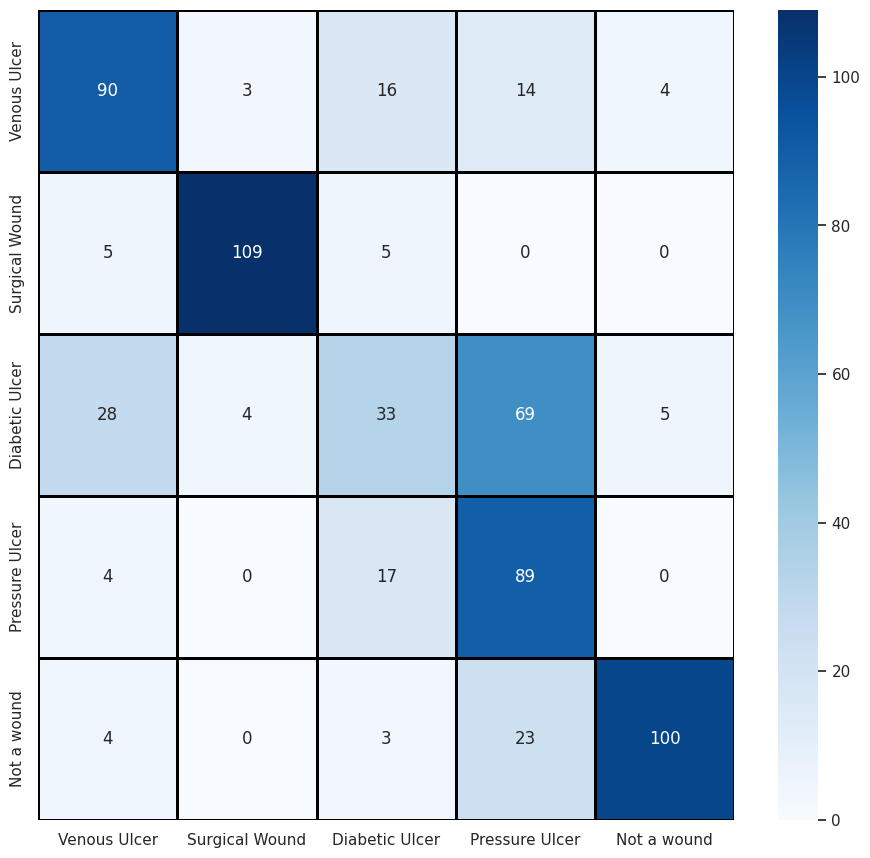

In [ ]:
# Plot confusion matrix for Model 3

cm = confusion_matrix(rounded_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3','4'], columns = ['0', '1', '2', '3','4'])
plot_confusion_matrix(cm)

3.5.4 ) TRAINING THE ENTIRE MODEL FROM SCRATCH
Finally I have tried to train the model from scratch. Note this is not reasonable though as our data is also not much similar with the imagenet data plus we are quite short of data as we only have around 4200 images.

Hence this model is quite prone to overfitting and I have done this just to check that the results validate with the though-process.

4 ) Visualizing Predictons on the Validation Set


In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)


20/20 [==============================] - 1s 73ms/step


In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
print(prop_class)

[0, 5, 7, 8, 9, 10, 12, 14]


CORRECTLY CLASSIFIED WOUND IMAGES¶


ValueError: y should be a 1d array, got an array of shape () instead.

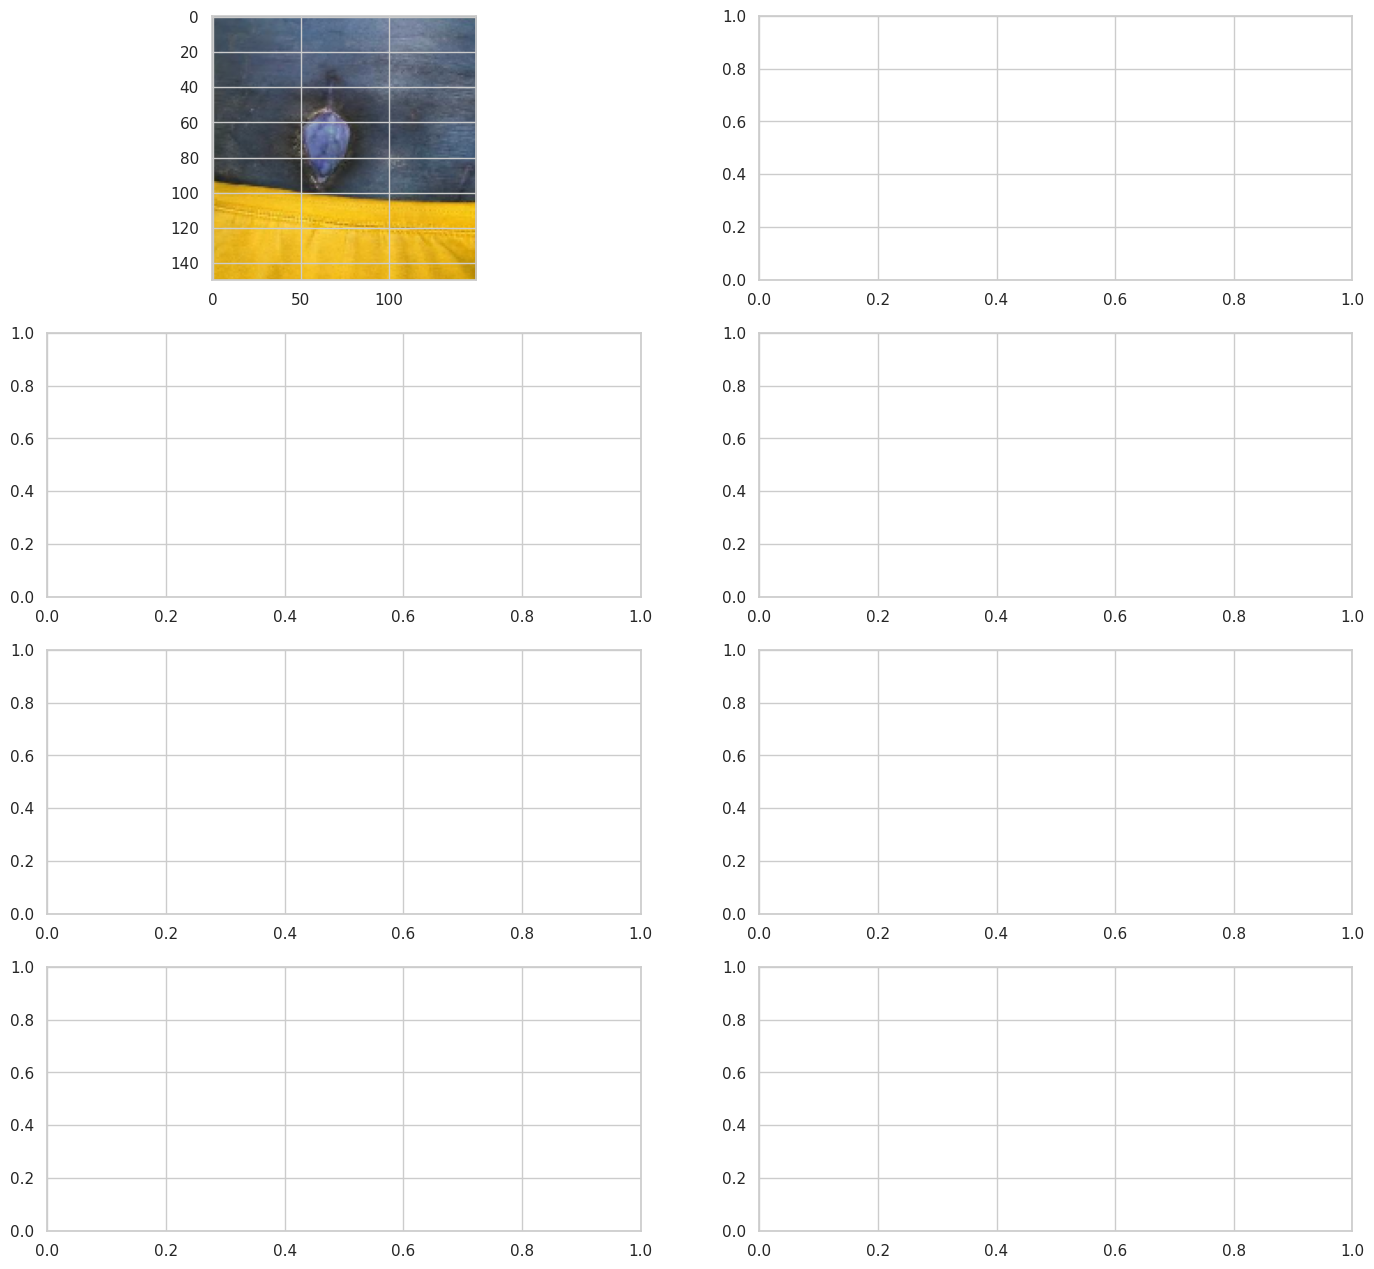

In [ ]:
warnings.filterwarnings('ignore')

count=1
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Wound : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Wound : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

MISCLASSIFIED IMAGES OF WOUND


In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Wound : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Wound : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1